# uMAIA Overview

This tutorial will introduce you to the usage of uMAIA, a toolbox designed for the processing and analysis of MALDI-MSI data. 

The whole pipeline of uMAIA consists of 3 parts as the following figure suggests:


<div>
<center>
<img src="figs/MAIA workflow.png" width="800">
</center>
</div>

The uMAIA package consists of 3 main modules: <code>peak_finding (pf)</code>, <code>molecular_matcher (mm)</code> and <code>normalizer (norm)</code>. In addition to that there are two other modules to help with loading the data in different stages and visualization, namely <code>utils (ut)</code> and <code>visualize (vis)</code>.

In [1]:
import uMAIA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

## Step 1: Image Extraction using adaptive Peak Finder

***uMAIA*** identifies more molecules than other freely-available software, imaging them automatically with higher quality.

To load the raw data you need to specify the path to the **IBD** and **imzml** files, which contain the raw output of MALDI mass spectrometer and the correspoding metadata.

In [5]:
path_data = '/data/SV_DAngelo/Leila/MALDI-MSI/MAIA_zebrafish/Atlases/72hpf/Atlas_72hpf_fish2/'
path_save = 'data'
name = '20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um'

# create directories
uMAIA.ut.tools.createSaveDirectory(path_save)
uMAIA.ut.tools.createSaveDirectory(os.path.join(path_save, name))

smz = uMAIA.ut.SmzMLobj(f'{os.path.join(path_data,name,name)}.IBD',
                           f'{os.path.join(path_data,name,name)}.imzml',
                           mz_resolution=10e-5)

smz.load(load_unique_mz=True)
smz.S

You can visualize the raw frequencies of mass-to-charge ratios, and check that the suggested parameters function for your specific dataset. Datasets with poorer mz resolution will require a higher value for the `smoothing` parameter, or a larger value for `mz_resolution` if one is aware of the approximate resolution of the instrument. 

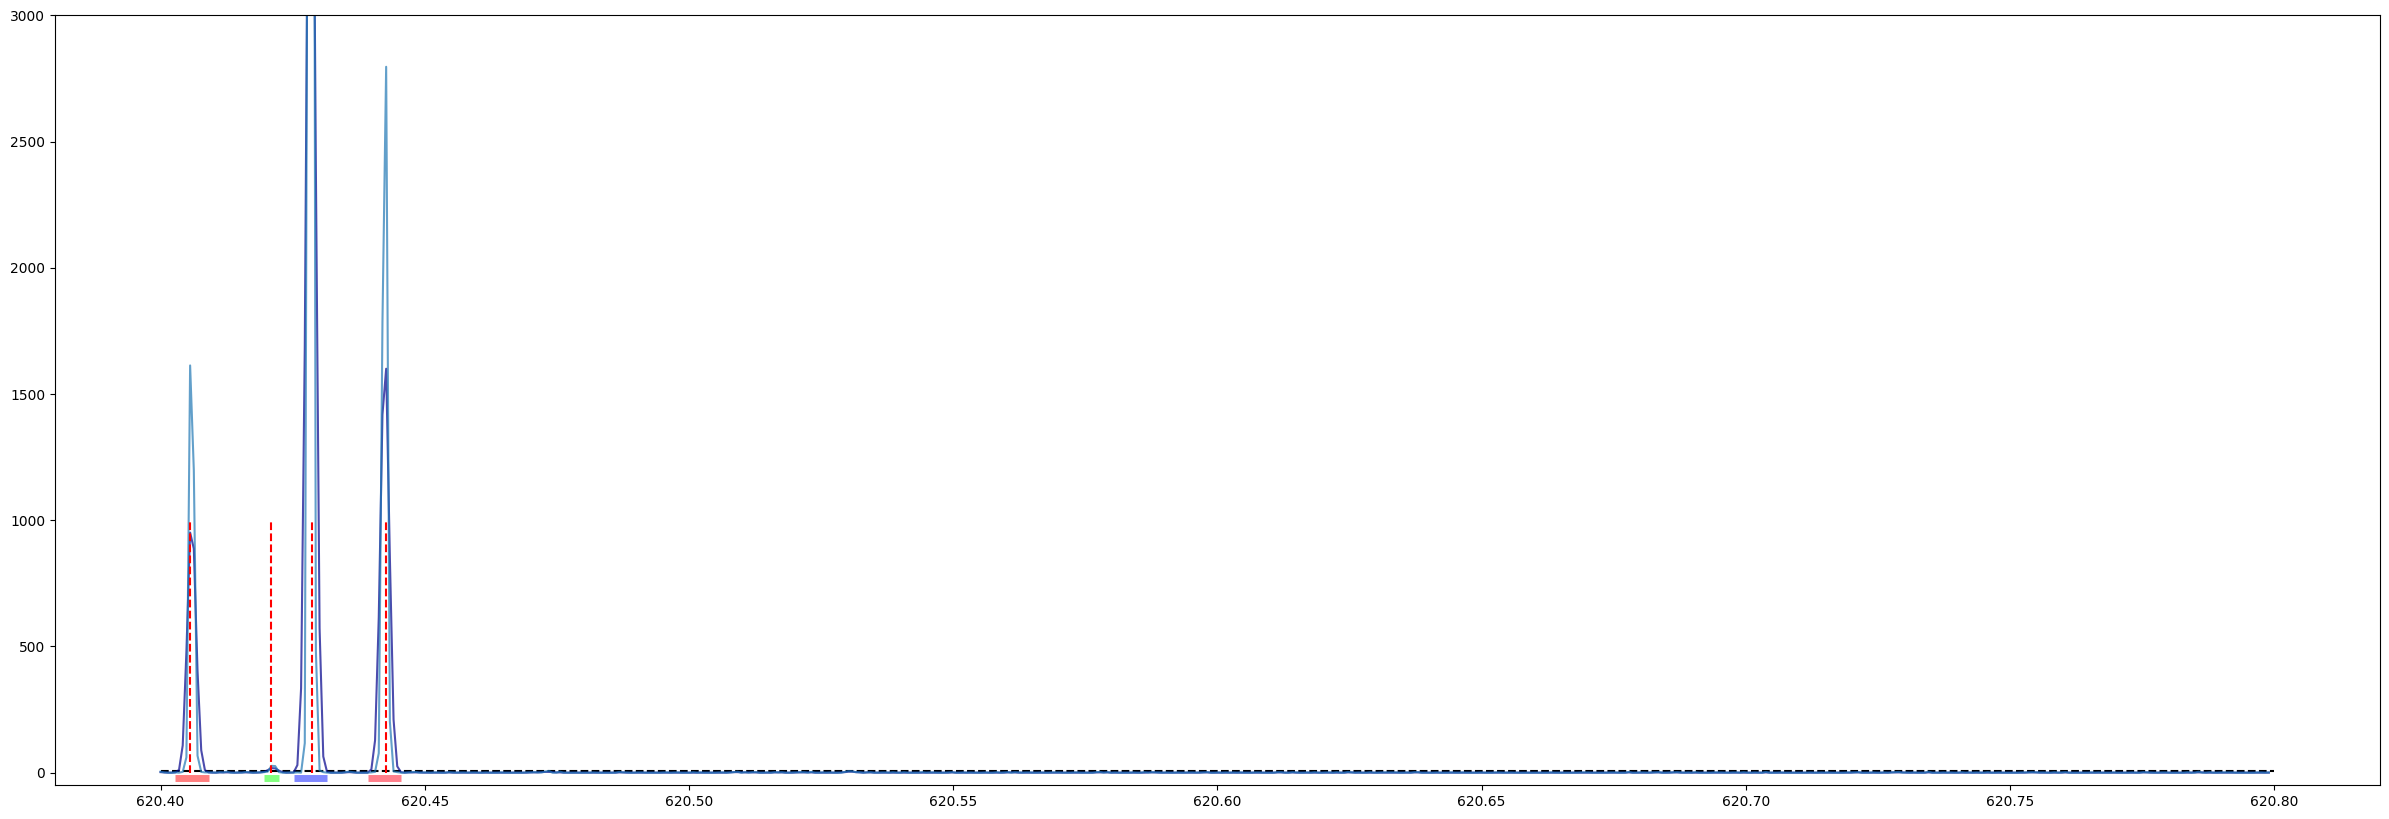

In [71]:
mz_resolution = 0.0001
threshold_count = 8.
approximate_interval =1.5
smoothing = 1. #2.5

mzrange_test = np.array([620.4,620.8])

PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=3000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

To identify the molecules you need to run the uMAIA peak finder with the specified parameters.

The output of the peak finder are the <code>images.h5ad</code> and <code>ranges.csv</code> files, which are then saved in the specified directory path.

In [72]:
uMAIA.pf.run(directory_path=os.path.join(path_save, name),
            smz=smz, 
            spectrum_range=(400,1200),
            threshold_count=threshold_count, 
            approximate_interval=approximate_interval,
            smoothing=smoothing,
            parallelize=True,
            saveimages=True)

Partioning m/z space and beginning peakcalling...


  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 107/107 [09:52<00:00,  5.53s/it]


Creating dataframe...


100%|██████████| 32358/32358 [02:32<00:00, 212.56it/s]


DataFrame created successfully
Removing temporary storage
Saving images...


100%|██████████| 32358/32358 [03:56<00:00, 136.63it/s]


Complete


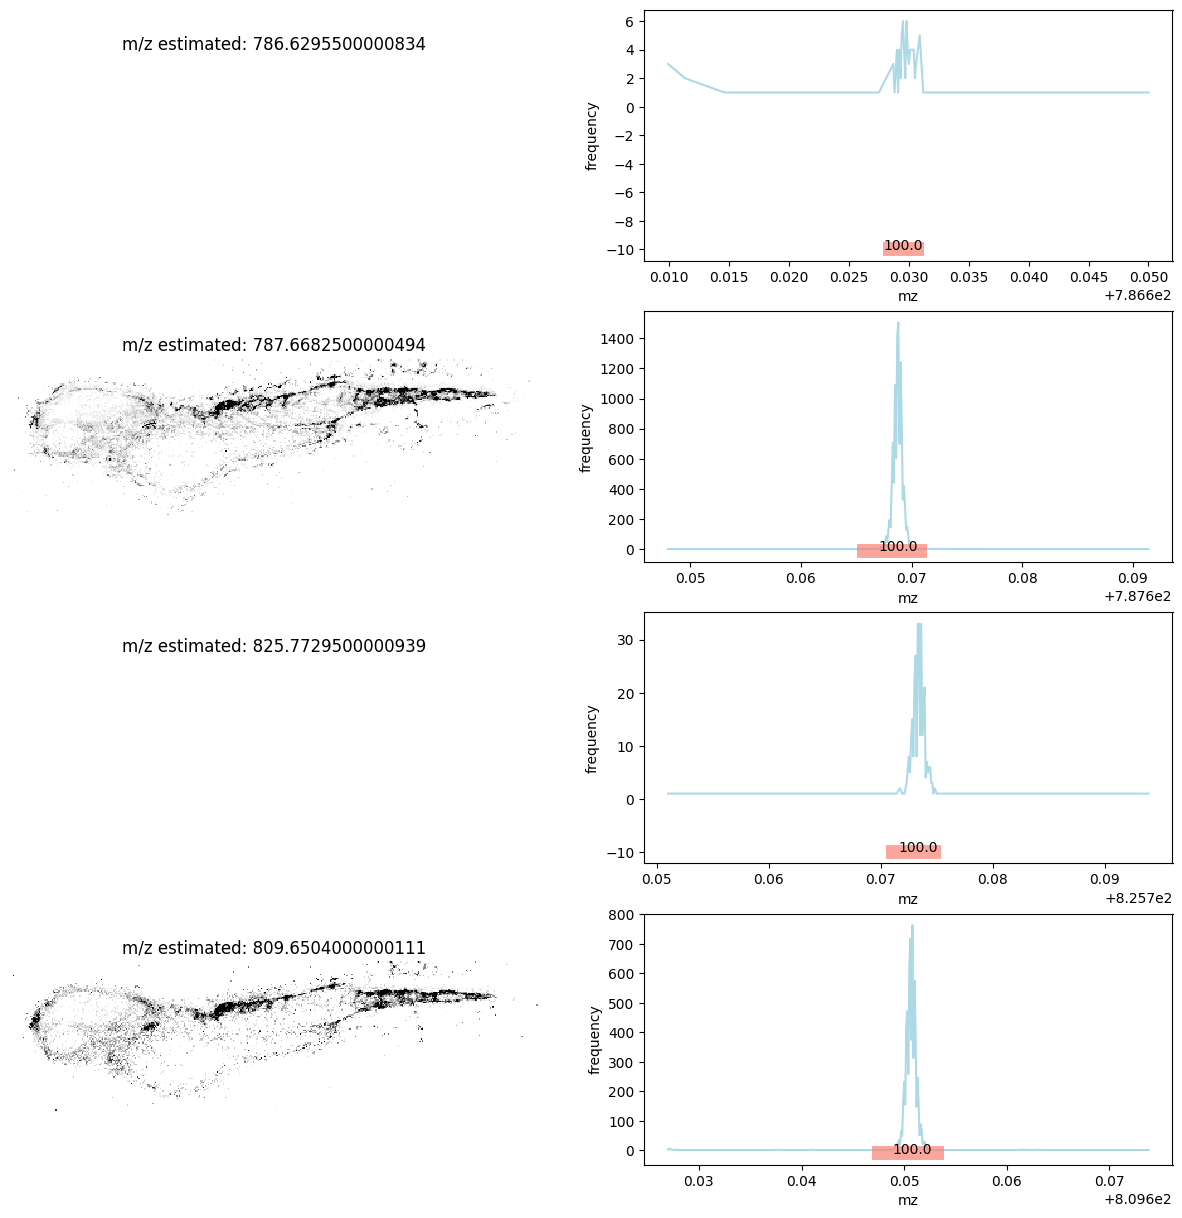

In [73]:
df_ranges = pd.read_csv(os.path.join(path_save, name, 'ranges.csv'), index_col=0)

adduct_H = 1.007
adduct_Na = 22.98977
adduct_K = 39.0983
adduct_NH4 = 14.0067 + 4 * adduct_H
s_mz =787.66876 - adduct_H


fig = uMAIA.vis.image_mz(smz, df=df_ranges, 
                             mz_list=[s_mz, s_mz + adduct_H, s_mz + adduct_K, s_mz + adduct_Na], 
                             cmap='Greys',figsize=(15,15),
                             img_shape=smz.img_shape, limit=0.01,clip=99,
                            )

## Step 2: Molecule Matching

***uMAIA*** retrieves identical molecules across acquistions without ambiguity.

In [6]:
acquisitions = [
    '20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um',
    '20220702_Zebrafish_atlas_72hpf_fish2_section_18_452x136_Att35_7um', #done
    '20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um', # done
    '20220621_Zebrafish_atlas_72hpf_fish2_section24_422x135_Att35_7um', # done
    '20220620_Zebrafish_atlas_72hpf_fish2_section26_345x136_Att35_7um' # done
           ]

ranges_files = [os.path.join(path_save, name, 'ranges.csv') for name in acquisitions]
images_files = [os.path.join(path_save, name, 'images.h5ad') for name in acquisitions]


df_list = uMAIA.ut.tools.read_files(ranges_files) # load files
df_list = uMAIA.ut.tools.filterSparseImages(df_list, 3000) # filter sparse images (noise)

In [7]:
df_match = uMAIA.mm.match(MAX_DIST=0.005, df_list=df_list)
# filter out molecules that we are not interested in imaging
df_filter = uMAIA.mm.filter_matches(df_match, num_match=5) 
df_filter.sort_values(['molecule_ID', 'section_ix'], inplace=True)

print(f'Number of unique molecules after filtering: {len(df_filter.molecule_ID.value_counts())}')

  0%|          | 0/799 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-12


100%|██████████| 799/799 [01:09<00:00, 11.48it/s]


Number of unique molecules after filtering: 2177


In [8]:
# save the images to zarr format
PATH_SAVE = os.path.join(path_save, 'TestStack.zarr')
uMAIA.ut.tools.to_zarr(PATH_SAVE, acquisitions, df_filter, images_files)


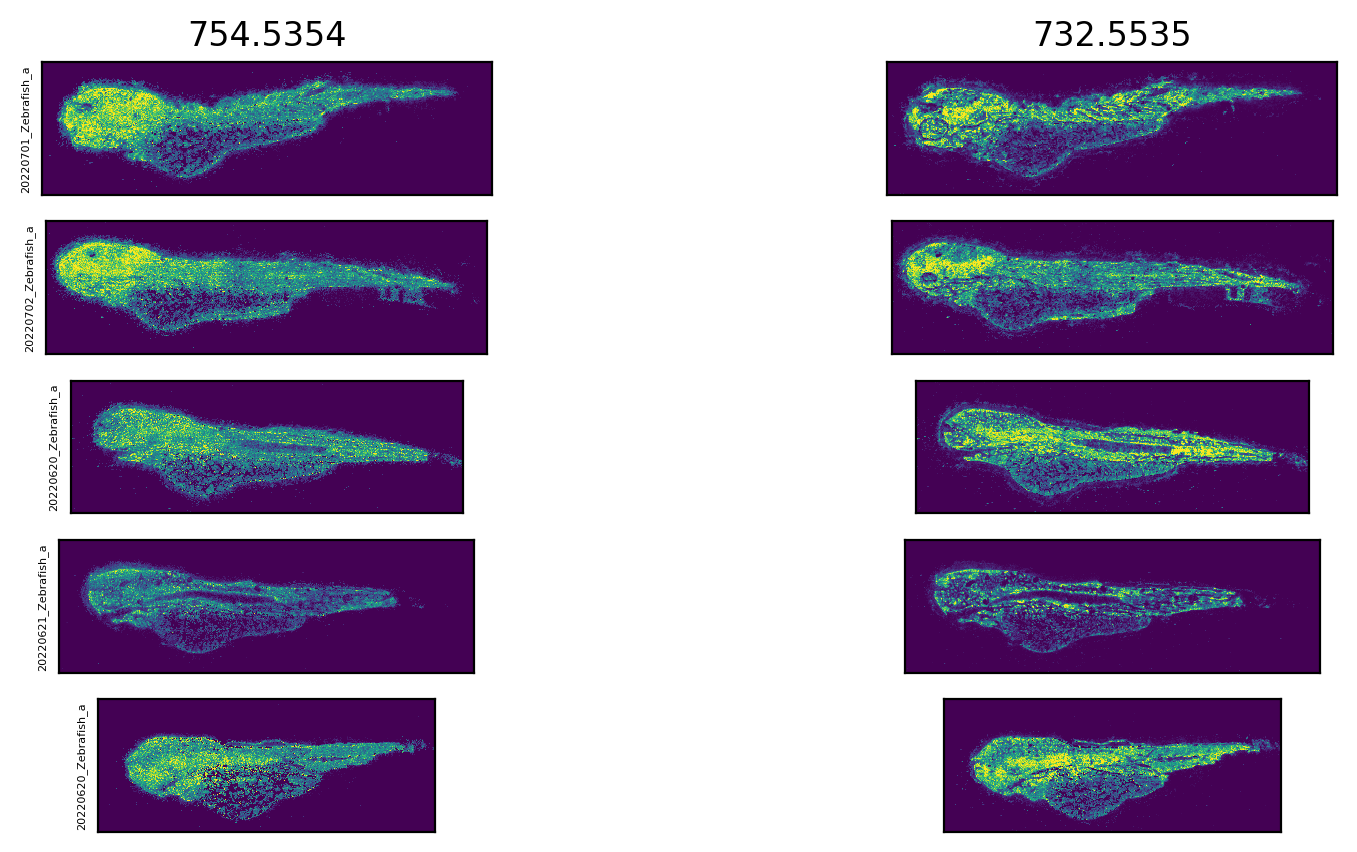

In [9]:
# visualize images
uMAIA.vis.showMatchedImages(PATH_SAVE, [754.5357,732.5538], acquisitions, figsize=(10,5))

## Step 3: Normalization

***uMAIA*** normalizes images by fitting a Bayesian model that accounts for different sources of noise in a regularized way and allows a conservative non-linear rescaling of intensity values such that qualifications can be properly compared across sections.

In [10]:
path_save = 'data'
PATH_SAVE = os.path.join(path_save, 'TestStack.zarr')

In [12]:
x, masks, masks_list = uMAIA.ut.tools.read_images_masks(acquisitions,
                                        path_images=PATH_SAVE, path_masks=None,
                                        gaussian_smoothing=True, gaussian_sigma=0.4,
                                        log_transform=True, epsilon=0.0002
                                       )

Loading Data...: 2177it [00:15, 140.85it/s]


Data Loaded Successfully.


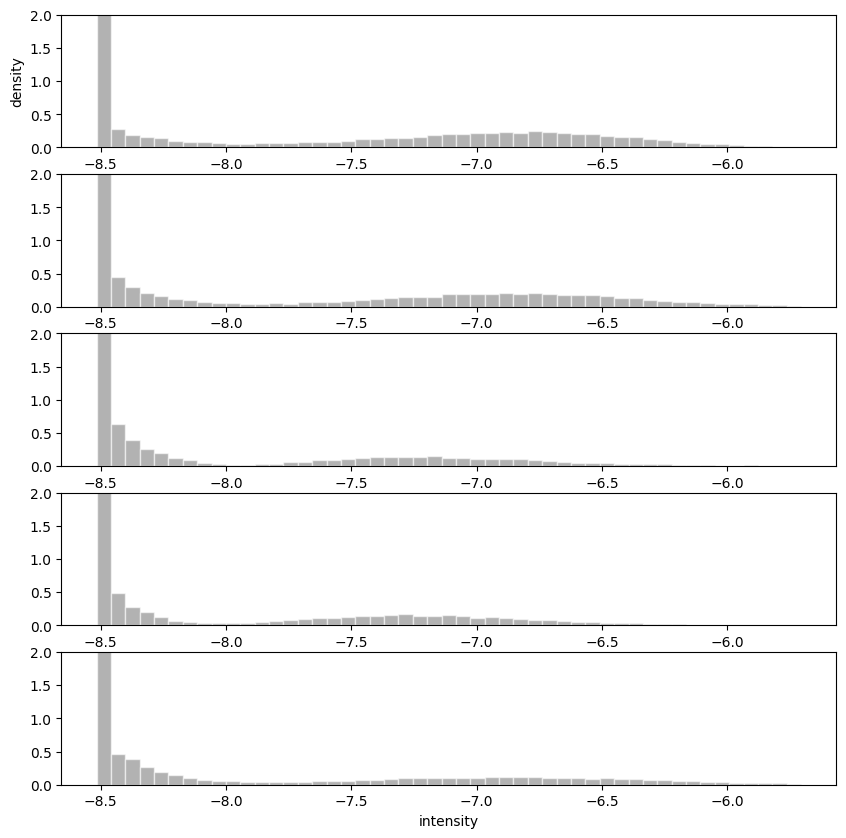

In [13]:
uMAIA.vis.plot_intensity(x, masks, v=50, mz_val=None)

We can model the MALDI-MSI data intensities’ histogram as a gaussian mixture model and approximate the true foreground distribution, where the non-biological batch effects have been taken into account. To normalize the data, uMAIA uses the following graphical model to address the batch effects.

<div>
<center>
<img src="figs/MAIA_PGM.png" width="800">
</center>
</div>

To initialize the SVI, we simply fit a GMM on the cumulative distribution of each molecule. We use BIC metric to choose whether a unimodal or bimodal gaussian distribution would fit the best on the intensities. It's also possible to intialize the required parameters manually and save them in a dictionary to pass for the normalization method.

In [14]:
init_state = uMAIA.norm.initialize(x, masks,  subsample=True)

GMM Initialization: 100%|██████████| 2177/2177 [01:04<00:00, 33.99it/s]
2023-10-05 09:46:50.482721: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.140). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [15]:
svi_result = uMAIA.norm.normalize(x, 
                              masks,
                              init_state=init_state,
                              subsample=True,
                              optimizer=None,
                              num_steps=5000,
                              seed=42)

100%|██████████| 5000/5000 [00:21<00:00, 228.64it/s, init loss: 1313731.2500, avg. loss [4751-5000]: -7162911.0000]


After normalization, you can save the parameters of interest using the utils module for further analysis.

In [16]:
PATH_SAVE = f'data/parameters_test'
try:
    os.mkdir(PATH_SAVE)
except:
    pass
uMAIA.ut.tools.save_svi(svi_result, PATH_SAVE)

Afterwards, you can transform your data to get the uMAIA normalized MALDI-MSI data and preform future downstream analysis.

In [17]:
x_tran = uMAIA.norm.transform(x, masks, svi_result)

You can visualize the raw intensities vs the normalized intensities and the fitted model in the same figure as well.

molecule susceptibility: 1.11


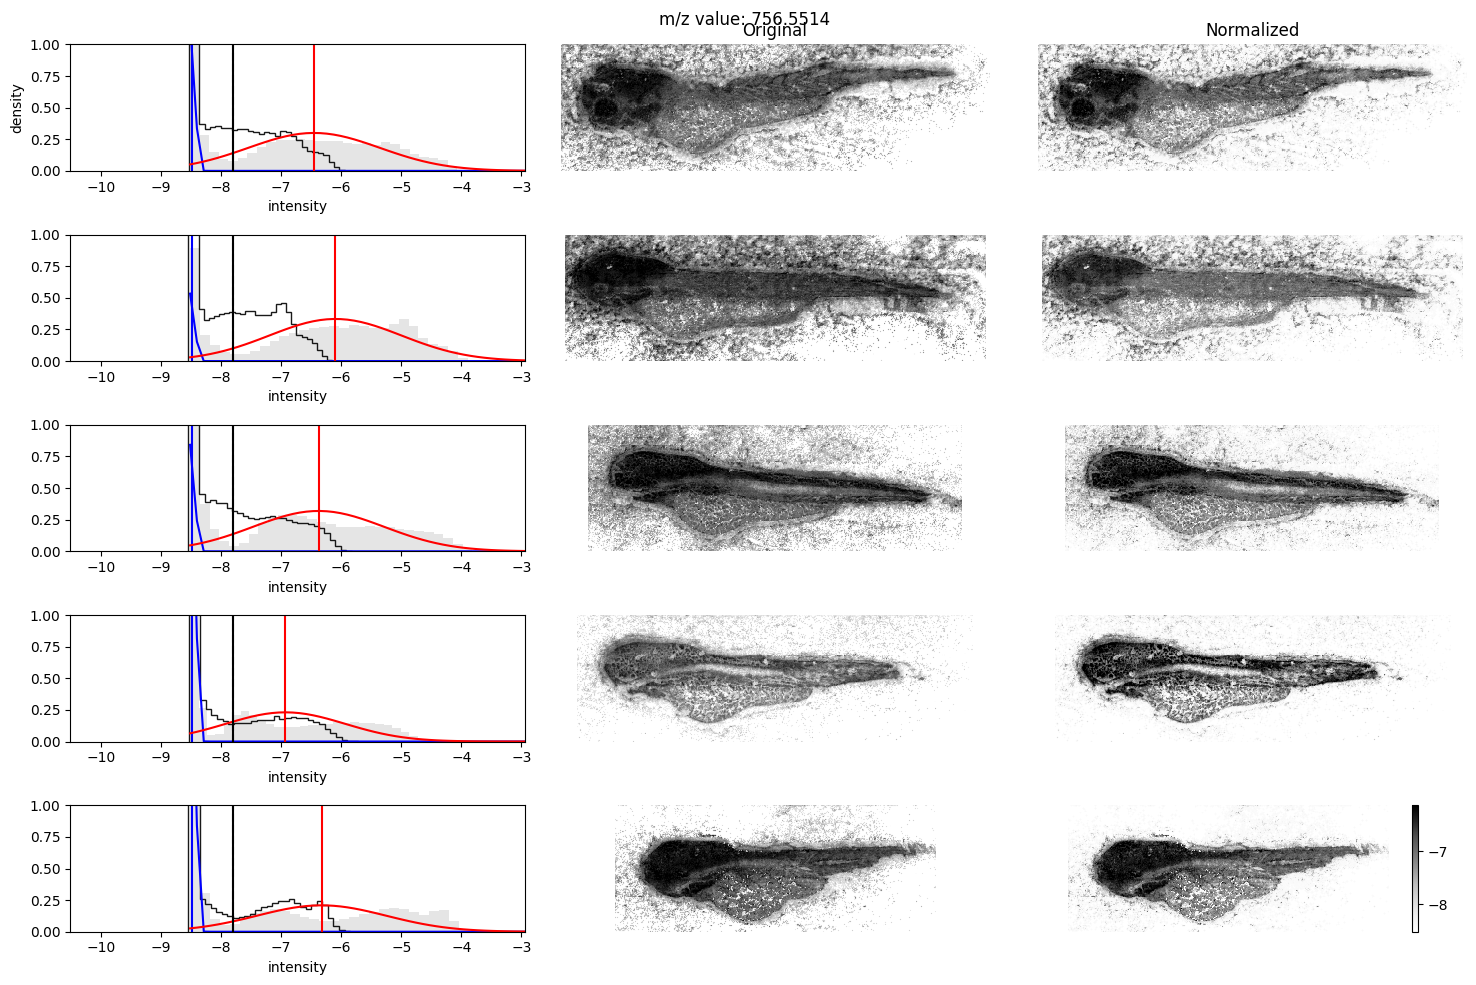

In [18]:
uMAIA.vis.normalized_hist(x_tran, x, masks, svi_result, zarr_path='data/TestStack.zarr', v_ind=None,mz_val=756.5514)

# example multivariate analysis

We begin by creating a matrix with pixels in rows and signals (metabolites) in columns 

In [20]:
import zarr
from scipy.ndimage.filters import median_filter, gaussian_filter
from scipy.ndimage.morphology import binary_erosion
from sklearn.decomposition import PCA

# create a list of 2D masks
root = zarr.open('data/TestStack.zarr', mode='rb')
mz_list = np.array(list(root.group_keys()))

mask_2D = []#root[mz_list[v]][i_s][:]
for s in list(root[mz_list[0]].keys()):
    mask_2D.append(
        np.ones_like(root[mz_list[0]][s][:]).astype(bool)
    )
mask_2D_tissue = [np.load(f'data/{a}/mask.npy') for a in acquisitions]

In [23]:
# place the images into the format specified
all_images_resized_MAIA = []
for v in range(x_tran.shape[2]):

    images_processed = []
    for s in range(x_tran.shape[1]):
        image_raw  = uMAIA.vis.place_image(mask_2D, x_tran, v, s,np.log(0.0002))
        image = median_filter(image_raw, 2)
        image = gaussian_filter(image, 0.5) # 0.5
        
        # put values back to min value outside of image
        image[mask_2D_tissue[s].astype(bool) == False] = np.nan
        
        images_processed.append(image)
    images = np.concatenate([x.flatten() for x in images_processed])
    all_images_resized_MAIA.append(images)

all_images_resized_MAIA = np.array(all_images_resized_MAIA)
R_MAIA = np.array(all_images_resized_MAIA)[:,np.concatenate([m.flatten() for m in mask_2D_tissue]).astype(bool)].T


mask_index_cumsum = np.insert(np.cumsum([x.sum().astype(int) for x in mask_2D_tissue]),0,0)
batch_ix = np.zeros(R_MAIA.shape[0])#np.zeros_like(labels)
for i, b in enumerate(mask_index_cumsum[1:]):
    batch_ix[mask_index_cumsum[i] : b] = i

We want to look into structure brought about by lipids. To do so we use only mz values which correpsond to known lipids before applying PCA

In [33]:
mz_lipids = [760.5851, 734.5694, 782.5670, 756.5514, 788.6164, 723.4935, 774.6007,
             697.4779, 784.5851, 746.5694, 786.6007, 522.3554, 577.5190, 703.5748,
             544.3373, 720.5538, 828.5514, 810.5983, 784.5827, 706.5381, 798.5408, 
             568.3397, 447.1261, 769.4779, 832.5851, 802.5357, 832.5827, 469.1857, 
             496.3397, 830.5670, 748.5851, 732.5538, 496.3397, 806.5694, 764.5225, 
             725.5568, 806.5670, 754.5357, 590.3217, 780.5514, 768.5514, 808.5827, 
             786.5044]

ix_select = []
for mz in mz_lipids:
    ix = np.argmin(np.abs(mz - mz_list.astype(float)))
    ix_select.append(ix)

# standardize the data
Ycnt = R_MAIA[:,ix_select]
Ycnt = Ycnt - Ycnt.mean(0)
Ystd = Ycnt / Ycnt.std(0)
Ystd = np.nan_to_num(Ystd)

R_pcs = PCA().fit_transform(Ystd)

now we can show the PCs by placing the pixels back into their respective sectoins

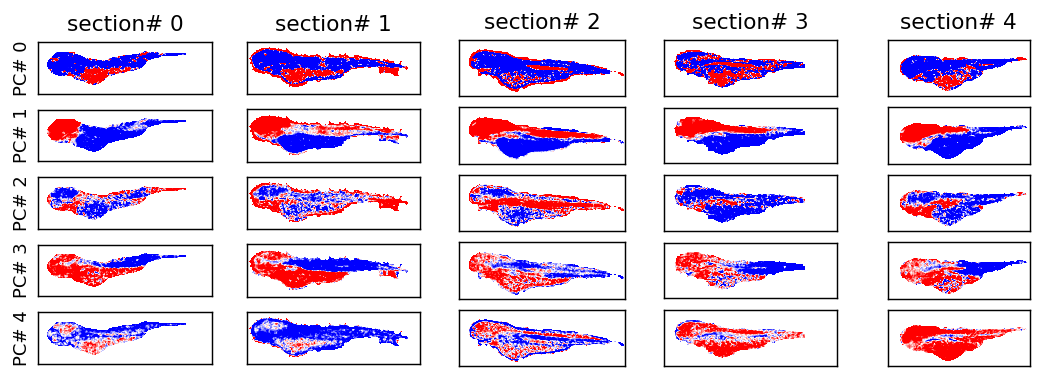

In [34]:
fig = plt.figure(None,(10,10), dpi=130)
gs = plt.GridSpec(15,x_tran.shape[1])
# take the PC


# mask_2D_tissue = []
for ip in range(5):
    R_pc = R_pcs[:,ip]
    for i_s, s in enumerate(np.unique(batch_ix).astype(int)):
        plt.subplot(gs[ip, i_s])

        if i_s == 0:
            plt.ylabel(f'PC# {ip}')

        if ip == 0:
            plt.title(f'section# {i_s}')
        # now find the indexes that belong to the section
        ix_s = batch_ix == s
        R_pc_s = R_pc[ix_s]
        vmin, vmax = np.percentile(R_pc_s, (5,95))
        vmax = np.max([np.abs(vmin), np.abs(vmax)])
        vmin = -vmax

        # put the image
        image = mask_2D_tissue[s].flatten().astype(bool)
        ix_ = np.argwhere(image).flatten()
        image = image.astype(float)
        image[:] = np.nan

        image[ix_] = R_pc_s
        image = image.reshape(mask_2D[s].shape)

        plt.imshow(image, cmap='bwr', vmin=-1, vmax=1)
        plt.yticks([])
        plt.xticks([])